Julia implementation of Wang & Wang 2011.

In [1]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

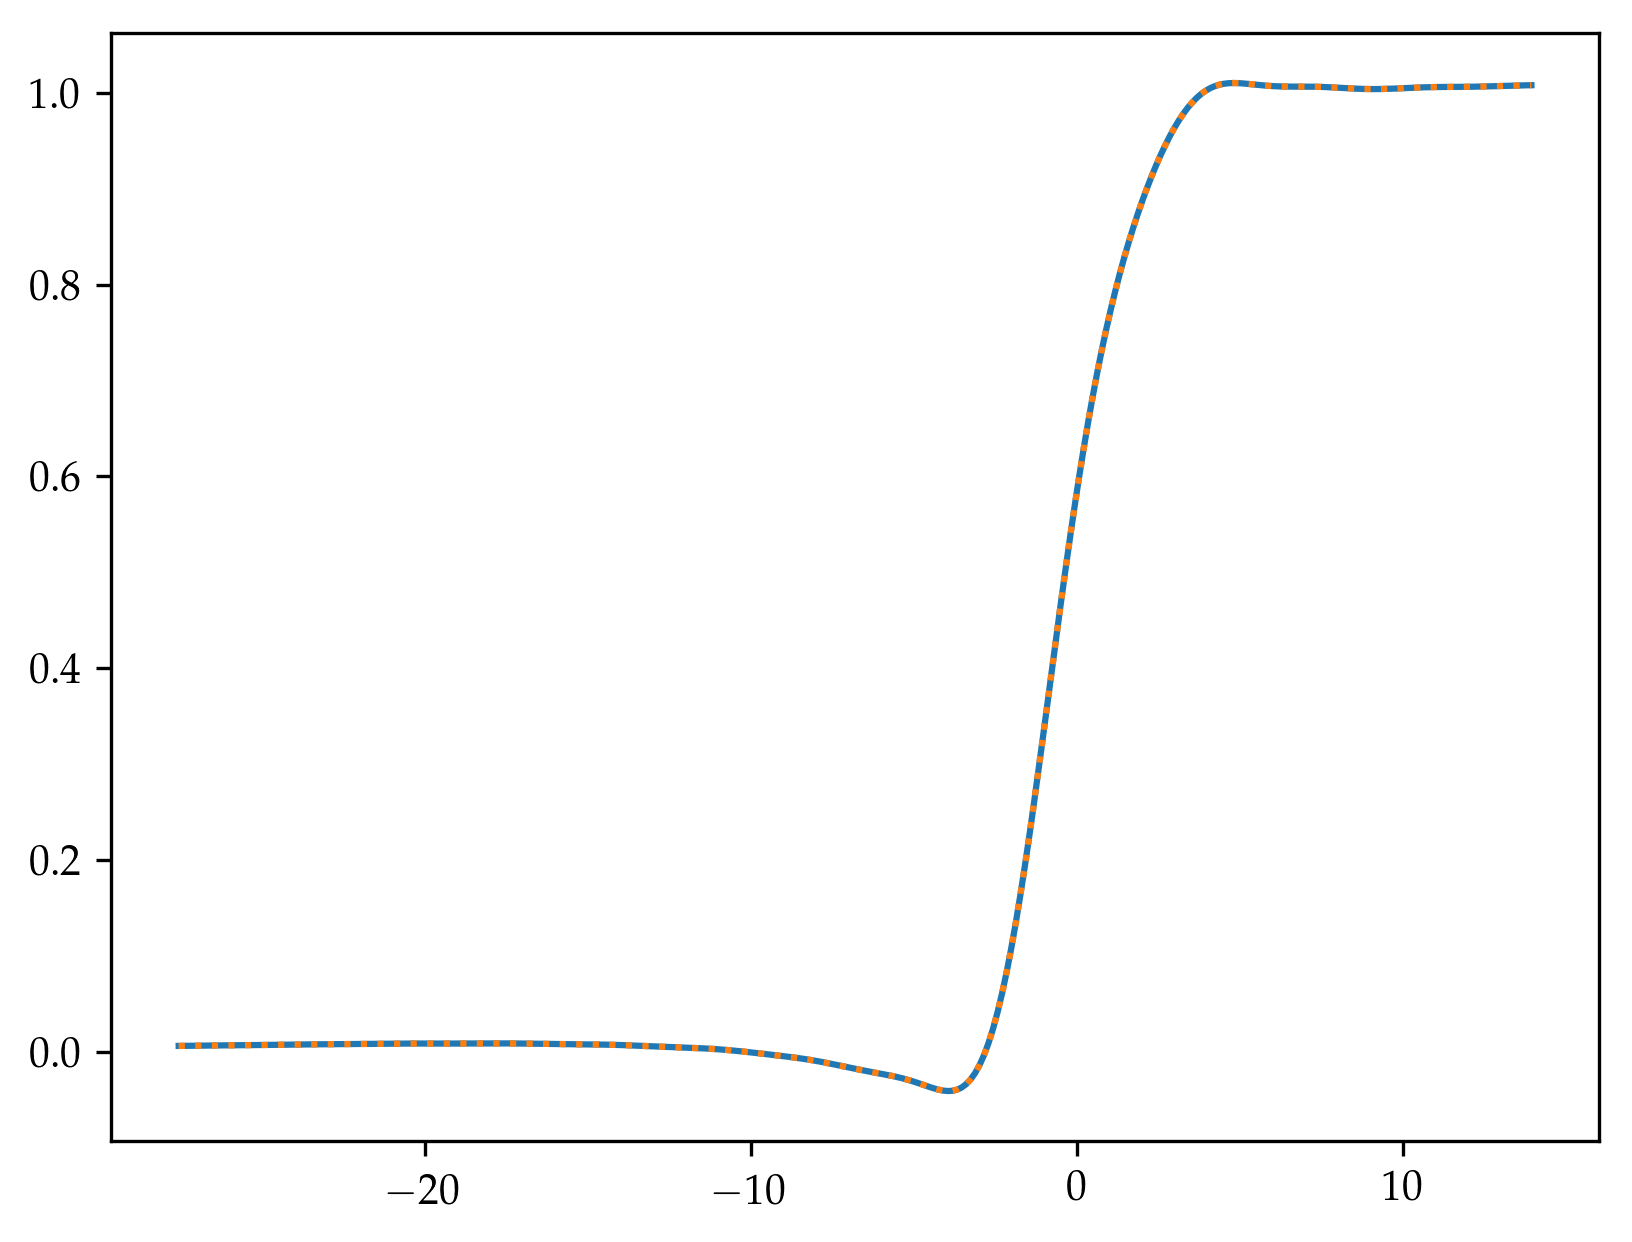

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11ff75860>

In [3]:
using DeconvolveDistribution
using Distributions

# simulate some data
n = 100
F_X = MixtureModel([Normal(-1, 1), Normal(2, 0.8)], [0.6, 0.4])
σ_distr = Gamma(1.0, 4.0)
srand(1)
X = rand(F_X, n)
σ = rand(σ_distr, n)
U_distr = Normal.(0.0, σ)
U = rand.(U_distr)
W = X .+ U

# estimate F_X from simulated data
n_xx = 300
F_xx = collect(linspace(extrema(W)..., n_xx))
num_t = 50
h = 0.5
Fhat_xx = Fhat(F_xx, W, num_t, h, U_distr)
plt.plot(F_xx, Fhat_xx)
Fhat_xx_brute = [DeconvolveDistribution.Fhatx_brute(x, W, num_t*2, h, U_distr) for x in F_xx]
plt.plot(F_xx, Fhat_xx_brute, ":")

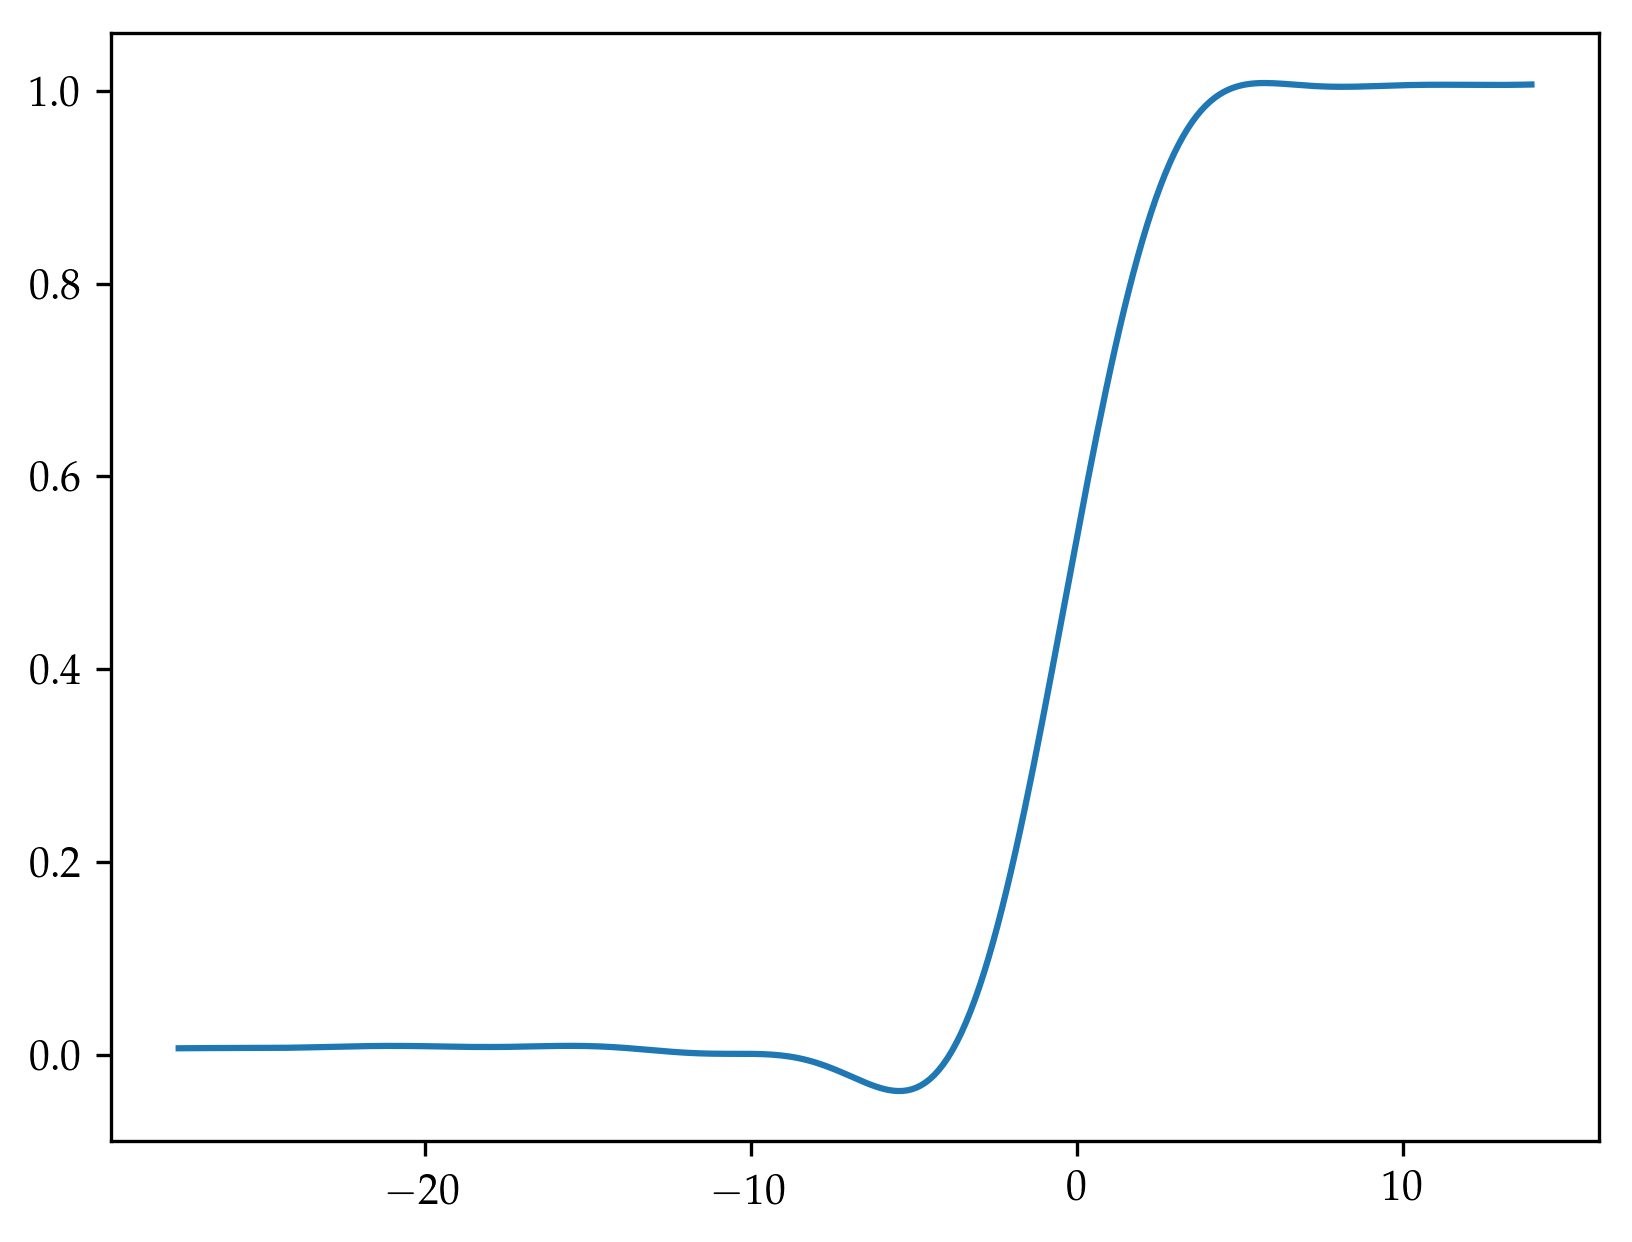

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12ae517f0>

In [7]:
n_xx = 300
F_xx = collect(linspace(extrema(W)..., n_xx))
num_t = 500
h = 1.0
Fhat_xx = Fhat(F_xx, W, num_t, h, U_distr)
plt.plot(F_xx, Fhat_xx)

In [2]:
using BenchmarkTools

In [499]:
Pkg.test("DeconvolveDistribution")

INFO: Testing DeconvolveDistribution


Test Summary: | Pass  Total
Fhat          |    4      4
Test Summary: | Pass  Total
fix_CDF       |  242    242


INFO: DeconvolveDistribution tests passed


In [1]:
using Distributions

In [19]:
?Distributions.cf

```
cf(d::UnivariateDistribution, t)
```

Evaluate the characteristic function of distribution `d`.


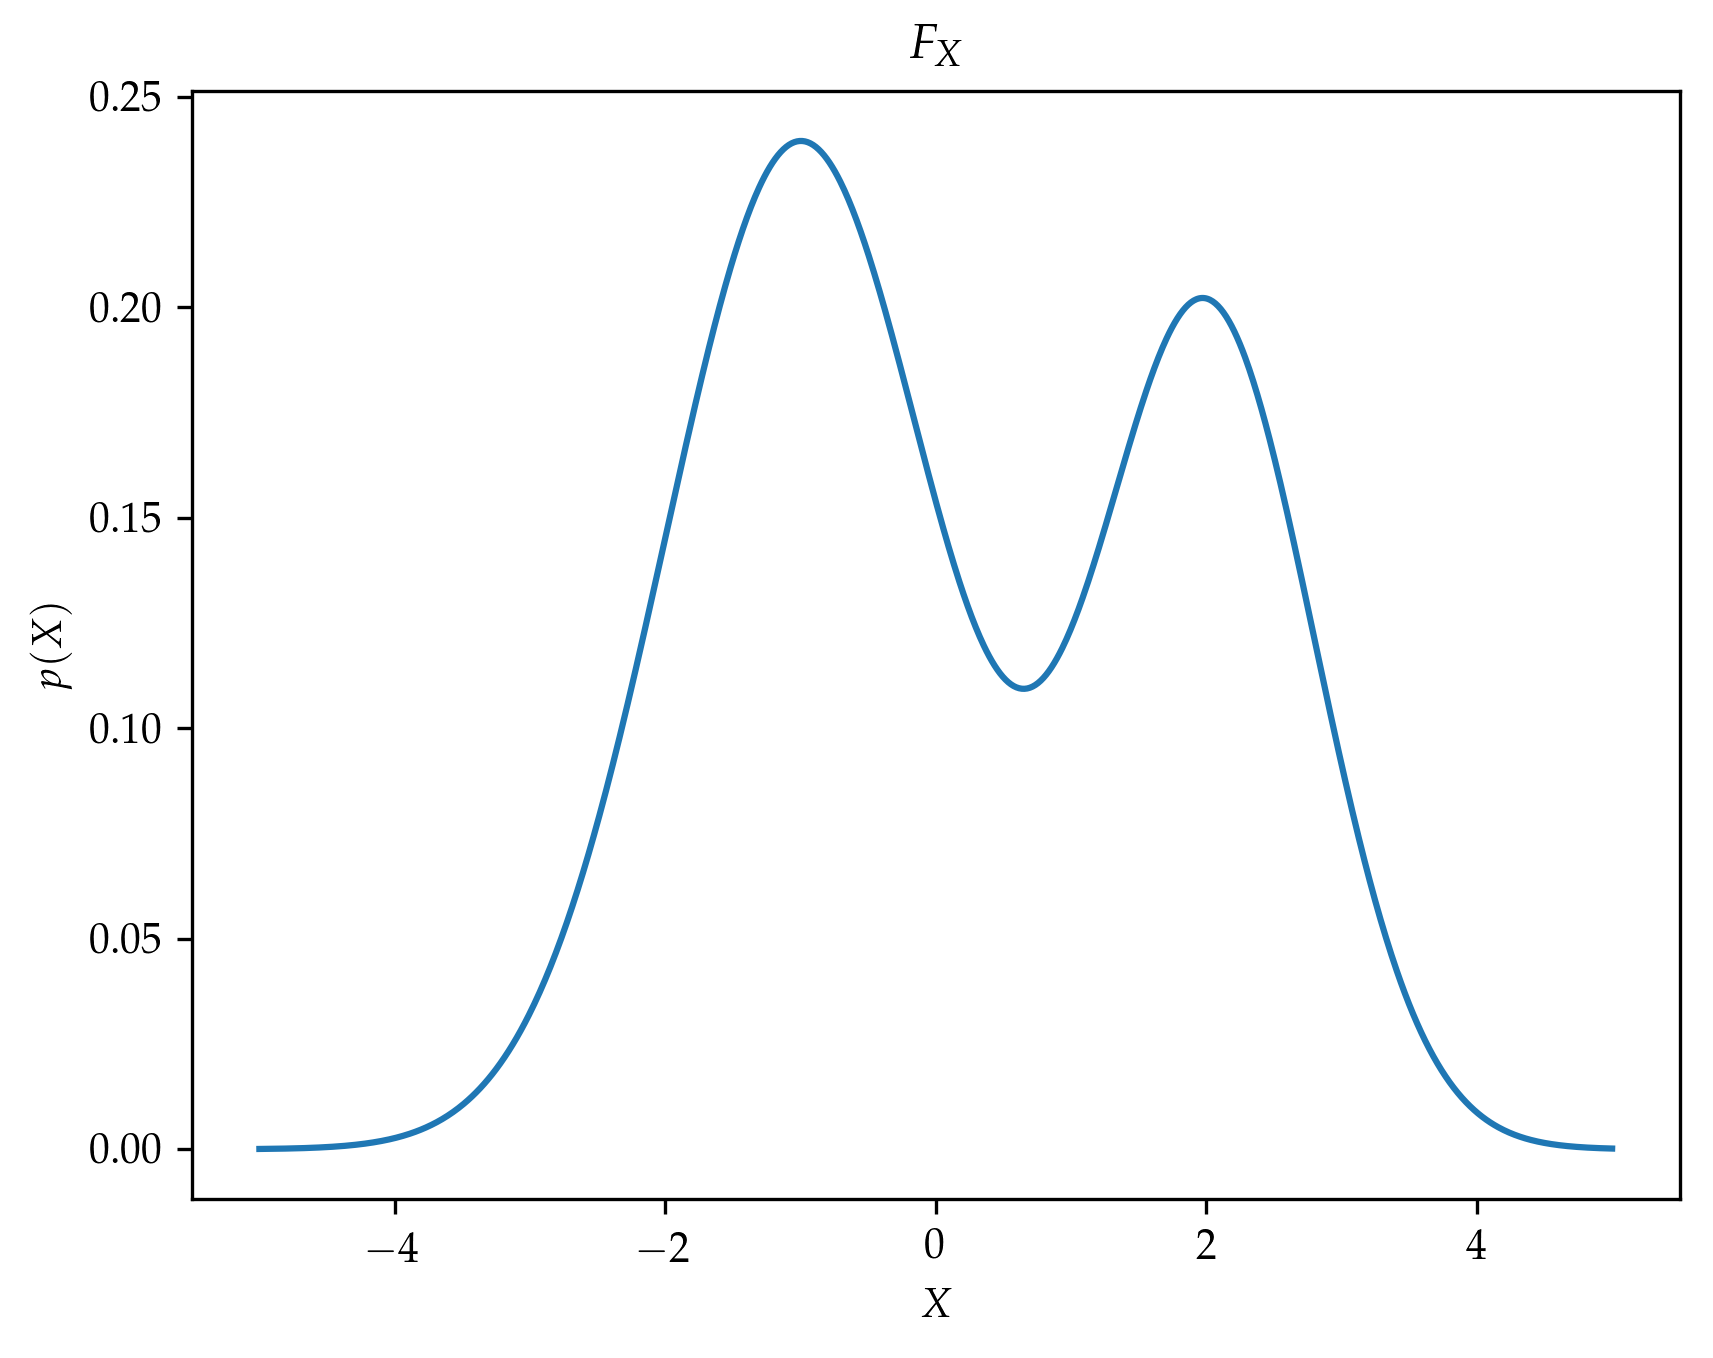

In [42]:
F_X = MixtureModel([Normal(-1, 1), Normal(2, 0.8)], [0.6, 0.4])
xx = linspace(-5, 5, 1000)
plt.plot(xx, pdf.(F_X, xx))
plt.title(L"$F_X$")
plt.xlabel(L"$X$")
plt.ylabel(L"$p(X)$")
;

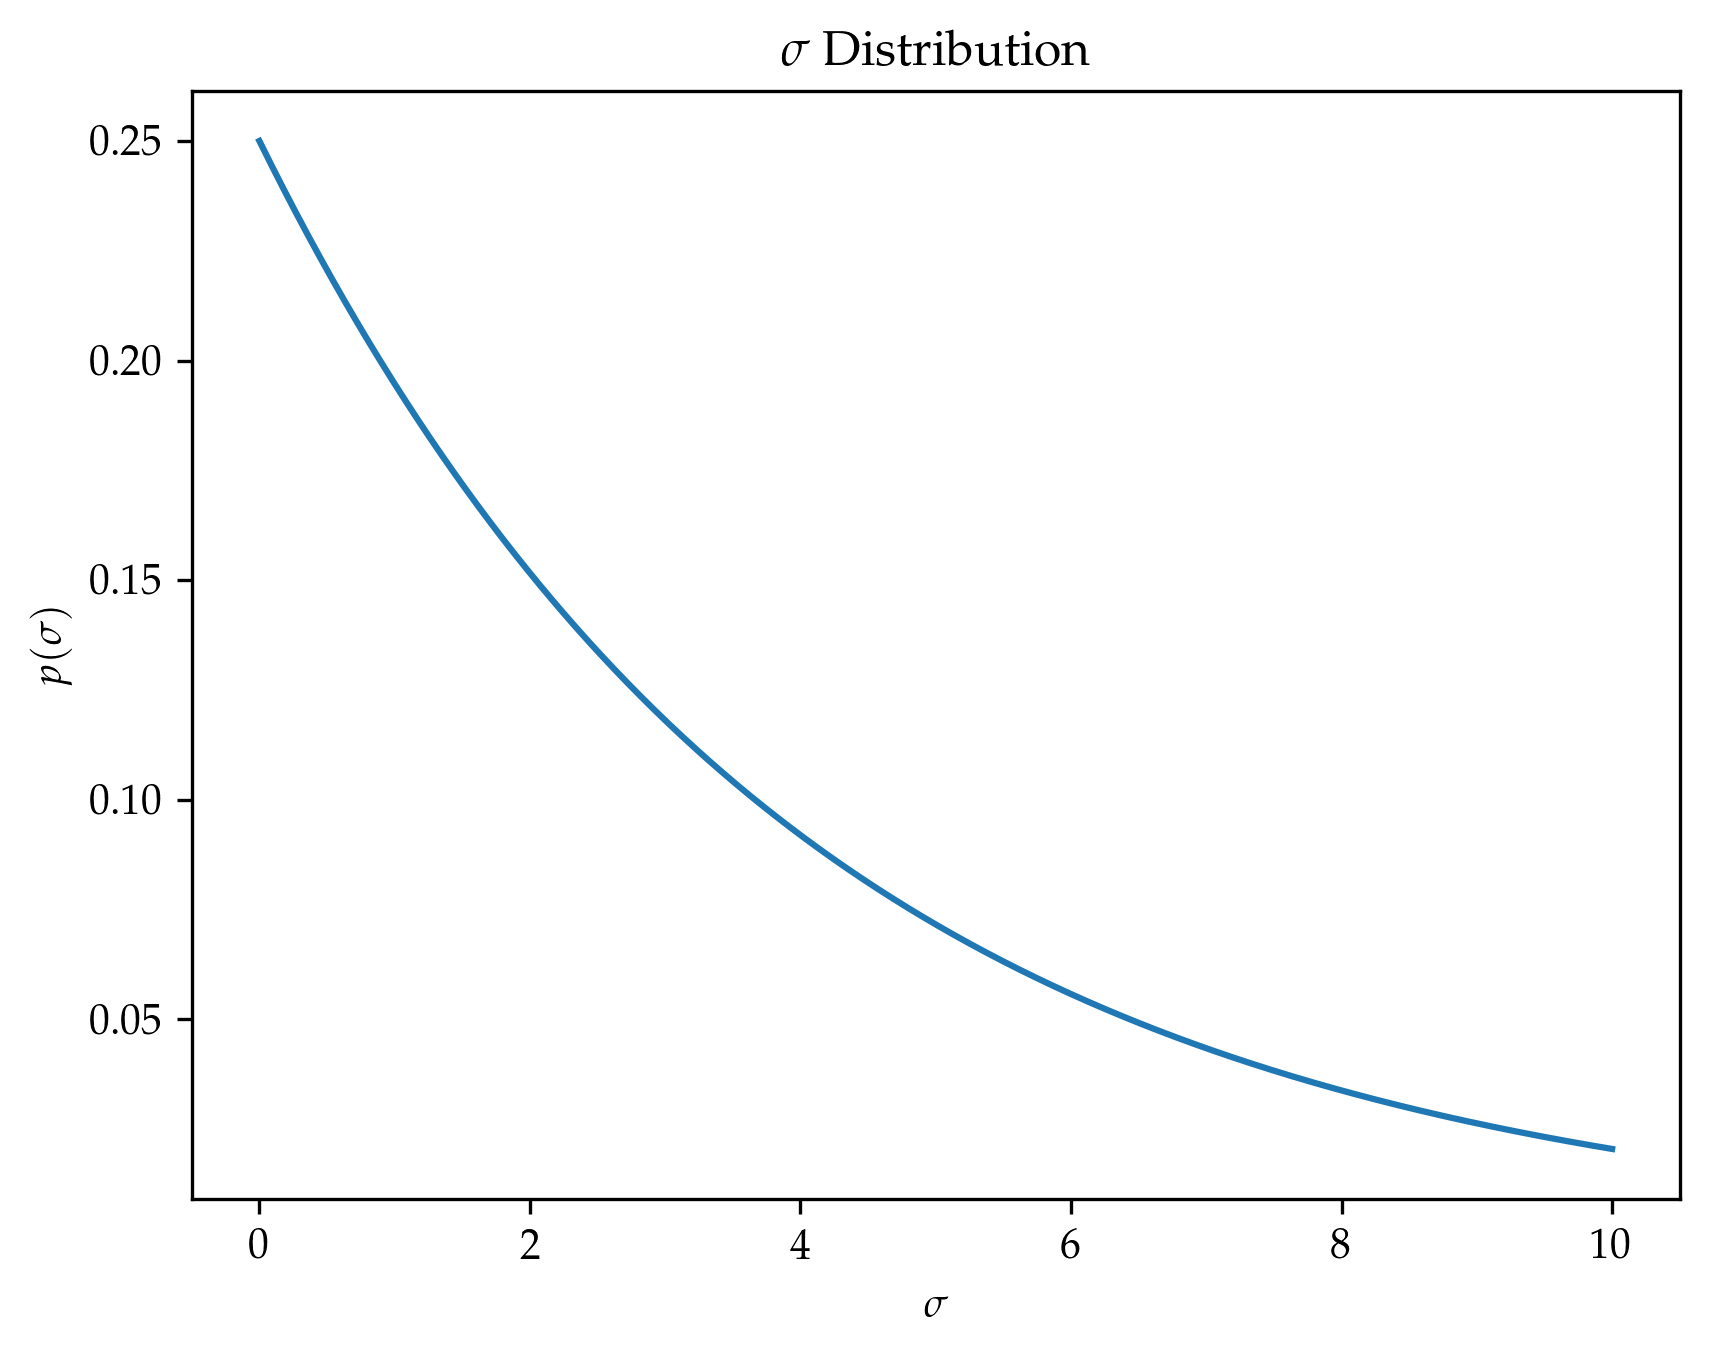

PyObject <matplotlib.text.Text object at 0x128999eb8>

In [13]:
σ_distr = Gamma(1.0, 4.0)
xx = linspace(0, 10.0, 1000)
plt.plot(xx, pdf.(σ_distr, xx))
plt.title(L"$\sigma$ Distribution")
plt.xlabel(L"$\sigma$")
plt.ylabel(L"$p(\sigma)$")

In [29]:
n = 300
srand(1)
X = rand(F_X, n)
σ = rand(σ_distr, n)
U = σ .* randn(n)
W = X .+ U
;

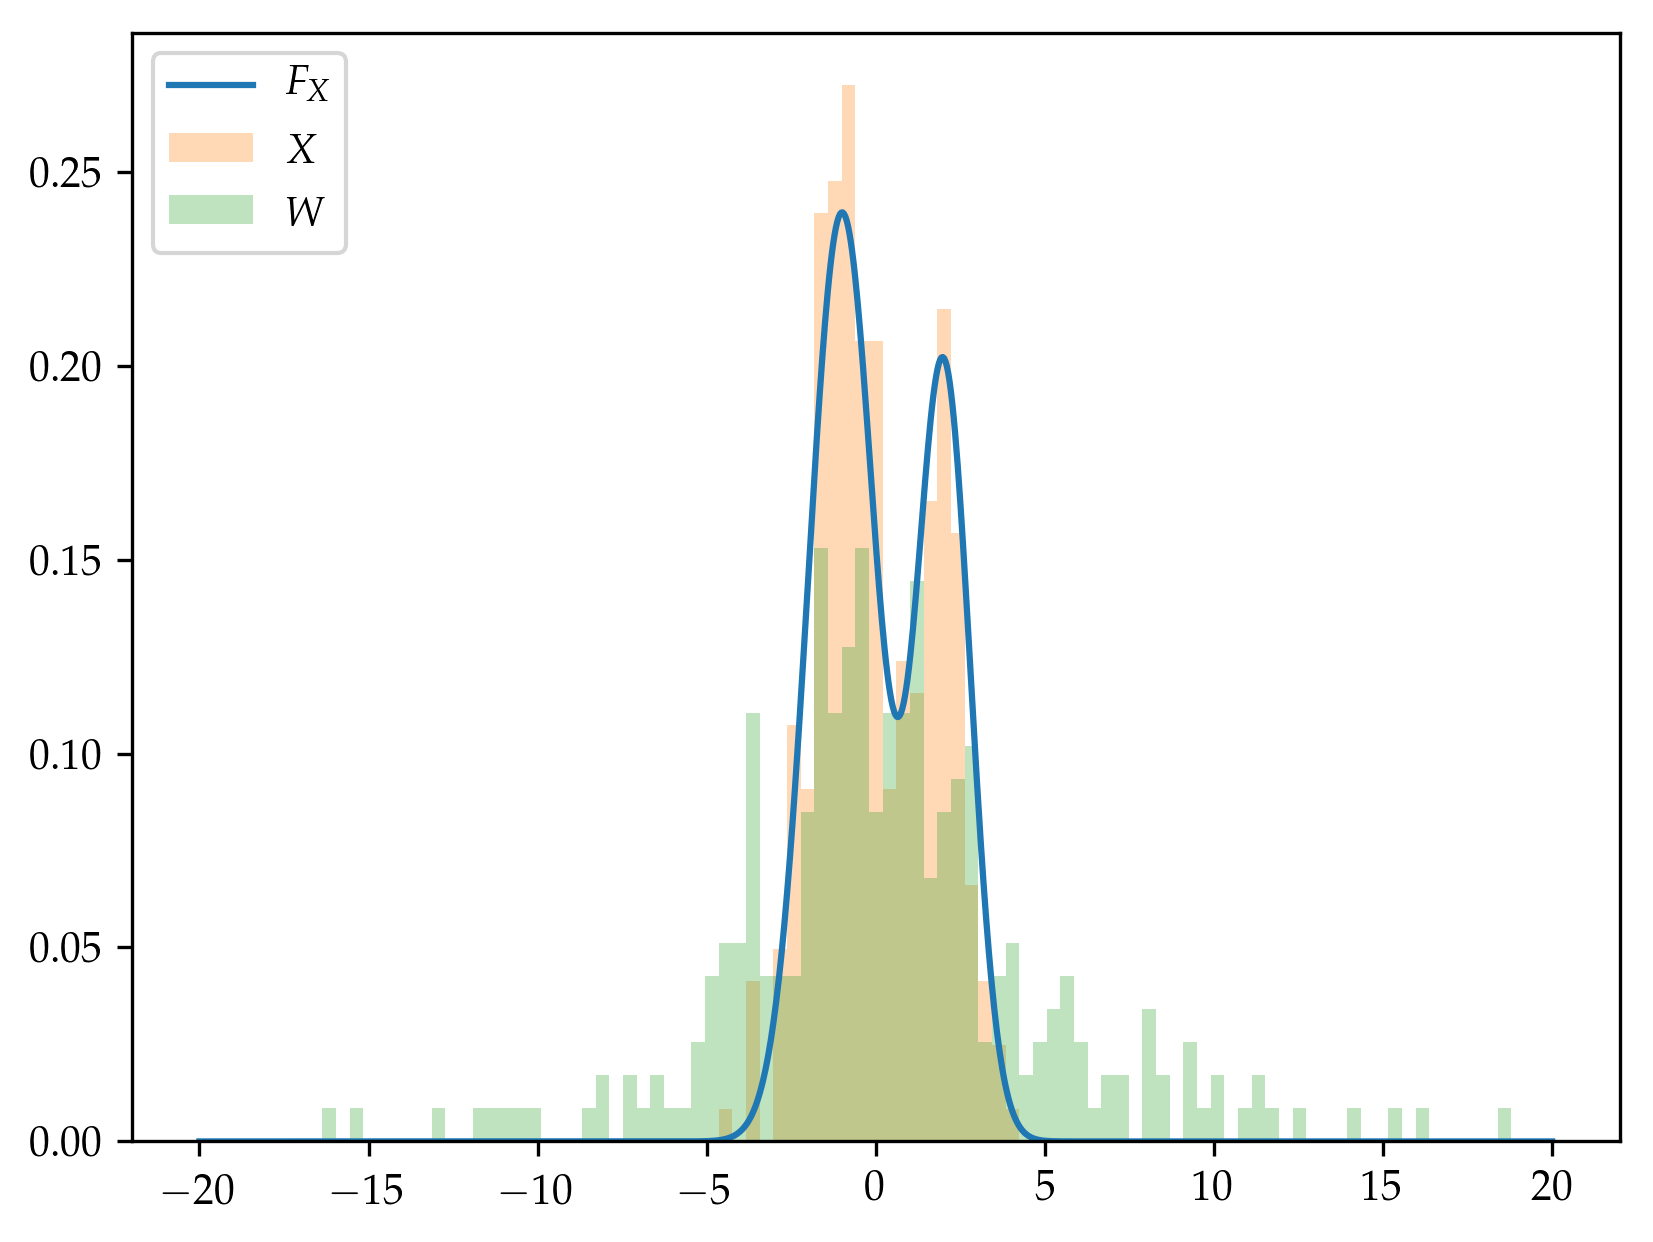

PyObject <matplotlib.legend.Legend object at 0x12ea2d3c8>

In [30]:
xx = linspace(-20, 20, 1000)
plt.plot(xx, pdf.(F_X, xx), label=L"$F_X$")
bins = linspace(-20, 20, 100)
plt.plt[:hist](X, normed=true, alpha=0.3, bins=bins, label=L"$X$")
plt.plt[:hist](W, normed=true, alpha=0.3, bins=bins, label=L"$W$")
plt.legend(loc="upper left")

In [113]:
module Rdecon
    using RCall
    R"""library("decon")"""
    function decon(X::Vector, σ_X::Vector, bw::Float64, grid::Vector; fixup=true)
        x_from = minimum(grid)
        x_to = maximum(grid)
        x_n = length(grid)
        @rput 
        Fhat_R = R"""
            Fhat <- DeconCdf($X, $σ_X, $grid, error = "normal", bw = $bw)
            Fhat$y
        """
        Fhat = convert(Vector{Float64}, Fhat_R)
        if fixup
            medianX = median(X)
            imedian = searchsortedfirst(grid, medianX)
            # monotonically increasing from median up
            Fhat[imedian:end] = accumulate(max, Fhat[imedian:end])
            # monotonically decreasing from median down
            Fhat[imedian:-1:1] = accumulate(min, Fhat[imedian:-1:1])
#             -0.1 < Fhat[1] < 0.2 || throw(AssertionError("Fhat[1] is $(Fhat[1])"))
#             0.90 < Fhat[end] < 1.05 || throw(AssertionError("Fhat[end] is $(Fhat[end])"))
            Fhat = min.(Fhat, 1.0)
            Fhat = max.(Fhat, 0.0)
            Fhat[1] = 0.0
            Fhat[end] = 1.0
        end
        return Fhat
    end
end

Rdecon

In [468]:
module Decon
    using Distributions
    using Distributions: cf
    using StatsBase: midpoints
    
    using FastGaussQuadrature
    
    function numerical_integration(x, y)
        weights = 0.5 .* ([0.0; diff(x)] .+ [diff(x); 0.0])
        return sum(weights .* y)
    end
    
    ϕK(t) = -1 < t < 1 ? (1.0-t^2) : 0.0
    
    """ 
        very literal implementation of equation 8.5
        in Wang&Wang 2011 (R decon paper)
    """
    function Fhatx_brute(x::Float64, W::AbstractVector, num_t::Int, h::Float64,
            U::AbstractVector{D} where D <: UnivariateDistribution)
        htt = linspace(-1.0, 1.0, num_t)
        tt = htt ./ h
        ϕKht = ϕK.(htt)
        @assert ϕKht[1] ≈ 0.0
        @assert ϕKht[end] ≈ 0.0
        n = length(W)
        s = 0.0
        sum_abs_ϕUkt = abs2.(cf.(U[1], tt))
        for k in 2:n
            sum_abs_ϕUkt .+= abs2.(cf.(U[k], tt))
        end
        mean_abs_ϕUkt = sum_abs_ϕUkt/n
        for j in 1:n
            sintxW = sin.(tt.*(x-W[j]))
            ϕUj = cf.(U[j], -tt)
            ψUj = mean_abs_ϕUkt ./ ϕUj
            s += numerical_integration(tt, sintxW .* ϕKht ./ tt ./ ψUj)
            isfinite(s) || throw(AssertionError("s=$s is not finite, j=$j"))
        end
        Fx = 0.5 + 1/(2π*n) * s
        @assert isfinite(Fx)
        (imag(Fx) ≈ 0.0) || AssertionError("Fx has non-negligible imaginary part $Fx") 
        return real(Fx)
    end
    
    @inline function real_cf_Uj_t(Uj::UnivariateDistribution, t::Float64)
        return @fastmath real(cf(Uj, t))
    end
    @inline function real_cf_Uj_t(Uj::Normal, t::Float64)
        # assume Uj has mean zero
        return exp(-var(Uj)*t^2/2)
    end
    
    function Fhat(xx::Vector{Float64}, W::Vector{Float64}, num_t::Int, h::Float64, 
            U::Vector{D} where D <: UnivariateDistribution)
        quad_nodes, t_weight = FastGaussQuadrature.gausslegendre(num_t)
        # FastGaussQuadrature outputs nodes from -1 to 1
        # we need nodes from 0 to 1
        htt = (quad_nodes .+ 1.0) ./ 2.0
        tt = htt ./ h
        ϕKht = ϕK.(htt)
        n = length(W)
        sum_abs_ϕUkt = abs2.(cf.(U[1], tt))
        for k in 2:n
            sum_abs_ϕUkt .+= abs2.(cf.(U[k], tt))
        end
        inv_mean_abs_ϕUkt = n ./ sum_abs_ϕUkt
#         ψUj = [(cf.(Uj, -tt) ./ mean_abs_ϕUkt) for Uj in U]
        F_xx = zeros(Float64, length(xx))
        @inbounds for (ix, x) in enumerate(xx)
            s = zero(Float64)
            for j in 1:n
                Wj = W[j]
                Uj = U[j]
                for (it, t) in enumerate(tt)
                    sinctxW = @fastmath sin(t*(x-Wj))/t
                    ϕUj = real_cf_Uj_t(Uj, -t)
                    s += t_weight[it] * sinctxW * ϕKht[it] * ϕUj * inv_mean_abs_ϕUkt[it]
#                     s += t_weight[it] * sintxW * ϕKht[it] / ψUj[j][it] / t
                end
            end
            F_xx[ix] = 0.5 + 1/(π*n) * s / (2*h) # 2h is the Jacobian
        end 
        return F_xx
    end
    function Fhat_cache(xx::Vector{Float64}, W::Vector{Float64}, num_t::Int, h::Float64, 
            U::Vector{D} where D <: UnivariateDistribution)
        quad_nodes, t_weight = FastGaussQuadrature.gausslegendre(num_t)
        # FastGaussQuadrature outputs nodes from -1 to 1
        # we need nodes from 0 to 1
        htt = (quad_nodes .+ 1.0) ./ 2.0
        tt = htt ./ h
        ϕKht = ϕK.(htt)
        n = length(W)
        sum_abs_ϕUkt = abs2.(cf.(U[1], tt))
        for k in 2:n
            sum_abs_ϕUkt .+= abs2.(cf.(U[k], tt))
        end
        inv_mean_abs_ϕUkt = n ./ sum_abs_ϕUkt
        s_cache = Vector{Float64}[]
        for j in 1:n
            Uj = U[j]
            sUj = real_cf_Uj_t.(Uj, -tt) .* inv_mean_abs_ϕUkt .* t_weight .* ϕKht
            push!(s_cache, sUj)
        end
        F_xx = zeros(Float64, length(xx))
        @inbounds for (ix, x) in enumerate(xx)
            s = zero(Float64)
            for j in 1:n
                Wj = W[j]
                Uj = U[j]
                scache_j = s_cache[j]
                for (it, t) in enumerate(tt)
                    sinctxW = @fastmath sin(t*(x-Wj))/t
                    scache_jt = scache_j[it]
                    s += scache_jt * sinctxW
#                     s += t_weight[it] * sintxW * ϕKht[it] / ψUj[j][it] / t
                end
            end
            F_xx[ix] = 0.5 + 1/(π*n) * s / (2*h) # 2h is the Jacobian
        end 
        return F_xx
    end
    
end

tt = collect(linspace(-1, 1, 100))
println("brute force: ", Decon.Fhatx_brute(-2.0, W, 100, 0.7, Normal.(0.0, σ)))
println("faster: ", Decon.Fhat([-2.0], W, 100, 0.7, Normal.(0.0, σ)))
println("cached: ", Decon.Fhat_cache([-2.0], W, 100, 0.7, Normal.(0.0, σ)))

brute force: 0.14426258372676887


faster: [0.144259]
cached: [0.144259]


In [452]:
@code_warntype Decon.Fhat([-2.0], W, 100, 0.7, Normal.(0.0, σ))

Variables:
  #self# <optimized out>
  xx::Array{Float64,1}
  W::Array{Float64,1}
  num_t::Int64
  h::Float64
  U::Array{Distributions.Normal{Float64},1}
  #13 <optimized out>
  k::Int64
  #temp#@_9::Int64
  it::Int64
  t::Float64
  #temp#@_12 <optimized out>
  sinctxW::Float64
  ϕUj::Float64
  #temp#@_15::Tuple{Int64,Int64}
  j::Int64
  Wj::Float64
  Uj::Distributions.Normal{Float64}
  #temp#@_19::Int64
  ix::Int64
  x::Float64
  #temp#@_22 <optimized out>
  s::Float64
  #temp#@_24::Tuple{Int64,Int64}
  #11 <optimized out>
  #12 <optimized out>
  quad_nodes::Array{Float64,1}
  t_weight::Array{Float64,1}
  #temp#@_29 <optimized out>
  htt <optimized out>
  tt <optimized out>
  ϕKht <optimized out>
  n@_33::Int64
  sum_abs_ϕUkt <optimized out>
  inv_mean_abs_ϕUkt <optimized out>
  F_xx::Array{Float64,1}
  T@_37 <optimized out>
  shape@_38 <optimized out>
  iter@_39 <optimized out>
  C@_40::Array{Float64,1}
  keeps@_41::Tuple{Tuple{Bool}}
  Idefaults@_42::Tuple{Tuple{Int64}}
  #temp#@_43 

      SSAValue(68) = (Core.tuple)(keep@_47::Tuple{Bool})::Tuple{Tuple{Bool}}
      SSAValue(69) = (Core.tuple)(Idefault@_48::Tuple{Int64})::Tuple{Tuple{Int64}}
      keeps@_41::Tuple{Tuple{Bool}} = SSAValue(68)
      Idefaults@_42::Tuple{Tuple{Int64}} = SSAValue(69) # line 270:
      # meta: location broadcast.jl _broadcast! 141
      # meta: location broadcast.jl # line 147:
      keep_1@_65::Tuple{Bool} = (Base.getfield)(keeps@_41::Tuple{Tuple{Bool}}, 1)::Tuple{Bool} # line 148:
      Idefault_1@_66::Tuple{Int64} = (Base.getfield)(Idefaults@_42::Tuple{Tuple{Int64}}, 1)::Tuple{Int64} # line 149:
      # meta: location simdloop.jl # line 66:
      #temp#@_62::Bool = false
      59: 
      unless (Base.not_int)(#temp#@_62::Bool)::Bool goto 105
      #temp#@_62::Bool = true # line 67:
      n#6036::Int64 = (Base.add_int)((Base.sub_int)(SSAValue(73), 1)::Int64, 1)::Int64 # line 68:
      unless (Base.slt_int)(0, n#6036::Int64)::Bool goto 103 # line 70:
      i#6037::Int64 = 0 # line 71:
 

      unless (Base.not_int)(#temp#@_177::Bool)::Bool goto 440
      #temp#@_177::Bool = true # line 67:
      n#6044::Int64 = (Base.add_int)((Base.sub_int)(SSAValue(262), 1)::Int64, 1)::Int64 # line 68:
      unless (Base.slt_int)(0, n#6044::Int64)::Bool goto 438 # line 70:
      i#6045::Int64 = 0 # line 71:
      NewvarNode(:(val_2@_170::Float64))
      NewvarNode(:(result@_171::Float64))
      406: 
      unless (Base.slt_int)(i#6045::Int64, n#6044::Int64)::Bool goto 436 # line 72:
      SSAValue(254) = (Base.add_int)(i#6045::Int64, 1)::Int64 # line 73:
      # meta: location broadcast.jl # line 151:
      SSAValue(256) = (Base.select_value)((Base.getfield)(keep_2@_182::Tuple{Bool}, 1)::Bool, SSAValue(254), (Base.getfield)(Idefault_2@_184::Tuple{Int64}, 1)::Int64)::Int64 # line 153:
      $(Expr(:inbounds, true))
      val_2@_170::Float64 = (Base.arrayref)(SSAValue(268), SSAValue(256))::Float64
      $(Expr(:inbounds, :pop)) # line 155:
      # meta: location  #12 0
      #temp#@_185

      SSAValue(359) = (Base.select_value)((Base.getfield)(keep_1@_237::Tuple{Bool}, 1)::Bool, SSAValue(357), (Base.getfield)(Idefault_1@_240::Tuple{Int64}, 1)::Int64)::Int64
      SSAValue(361) = (Base.select_value)((Base.getfield)(keep_3::Tuple{Bool}, 1)::Bool, SSAValue(357), (Base.getfield)(Idefault_3::Tuple{Int64}, 1)::Int64)::Int64 # line 153:
      $(Expr(:inbounds, true))
      val_1@_223::Float64 = (Base.arrayref)(C@_146::Array{Float64,1}, SSAValue(359))::Float64
      $(Expr(:inbounds, :pop))
      $(Expr(:inbounds, true))
      val_3::Float64 = (Base.arrayref)(SSAValue(372), SSAValue(361))::Float64
      $(Expr(:inbounds, :pop)) # line 155:
      # meta: location  #13 0
      #temp#@_243::Complex{Float64} = $(Expr(:invoke, MethodInstance for cf(::Distributions.Normal{Float64}, ::Float64), :(Decon.cf), SSAValue(371), :(val_3)))
      #temp#@_244::Float64 = (Base.add_float)((Base.mul_float)((Core.getfield)(#temp#@_243::Complex{Float64}, :re)::Float64, (Core.getfield)(#temp#@_243

      SSAValue(476) = (Core.tuple)((Base.getfield)(#temp#@_15::Tuple{Int64,Int64}, 1)::Int64, SSAValue(450))::Tuple{Int64,Float64}
      SSAValue(477) = (Core.tuple)((Base.add_int)((Base.getfield)(#temp#@_15::Tuple{Int64,Int64}, 1)::Int64, 1)::Int64, SSAValue(451))::Tuple{Int64,Int64}
      SSAValue(21) = SSAValue(476)
      SSAValue(478) = (Base.getfield)(SSAValue(21), 1)::Int64
      SSAValue(479) = (Base.add_int)(1, 1)::Int64
      it::Int64 = SSAValue(478)
      SSAValue(480) = (Base.getfield)(SSAValue(21), 2)::Float64
      SSAValue(481) = (Base.add_int)(2, 1)::Int64
      t::Float64 = SSAValue(480)
      #temp#@_15::Tuple{Int64,Int64} = SSAValue(477) # line 76:
      SSAValue(453) = $(Expr(:foreigncall, ("sin", "libopenlibm"), Float64, svec(Float64), :((Base.FastMath.mul_float_fast)(t, (Base.FastMath.sub_float_fast)(x, Wj)::Float64)::Float64), 0))
      sinctxW::Float64 = (Base.FastMath.div_float_fast)(SSAValue(453), t::Float64)::Float64 # line 77:
      SSAValue(454) = (Base.neg

In [453]:
@code_warntype Decon.Fhat_cache([-2.0], W, 100, 0.7, Normal.(0.0, σ))

Variables:
  #self# <optimized out>
  xx::Array{Float64,1}
  W::Array{Float64,1}
  num_t::Int64
  h::Float64
  U::Array{Distributions.Normal{Float64},1}
  #19 <optimized out>
  k::Int64
  #temp#@_9::Int64
  #20 <optimized out>
  j@_11::Int64
  Uj@_12::Distributions.Normal{Float64}
  ψUj@_13 <optimized out>
  #temp#@_14::Int64
  it::Int64
  t::Float64
  #temp#@_17 <optimized out>
  sinctxW::Float64
  ϕUjt::Float64
  #temp#@_20::Tuple{Int64,Int64}
  Wj::Float64
  j@_22::Int64
  Uj@_23 <optimized out>
  ψUj@_24::Array{Float64,1}
  #temp#@_25::Int64
  ix::Int64
  x::Float64
  #temp#@_28 <optimized out>
  s::Float64
  #temp#@_30::Tuple{Int64,Int64}
  #17 <optimized out>
  #18 <optimized out>
  quad_nodes::Array{Float64,1}
  t_weight::Array{Float64,1}
  #temp#@_35 <optimized out>
  htt <optimized out>
  tt <optimized out>
  ϕKht <optimized out>
  n@_39::Int64
  sum_abs_ϕUkt <optimized out>
  inv_mean_abs_ϕUkt <optimized out>
  ψU_cache::Array{Array{Float64,1},1}
  F_xx::Array{Float64,1}
  T@

      SSAValue(579) = (Base.getfield)(SSAValue(0), 1)::Array{Float64,1}
      SSAValue(580) = (Base.add_int)(1, 1)::Int64
      quad_nodes::Array{Float64,1} = SSAValue(579)
      SSAValue(581) = (Base.getfield)(SSAValue(0), 2)::Array{Float64,1}
      SSAValue(582) = (Base.add_int)(2, 1)::Int64
      t_weight::Array{Float64,1} = SSAValue(581) # line 91:
      $(Expr(:inbounds, false))
      # meta: location broadcast.jl broadcast 455
      # meta: location broadcast.jl broadcast_c 313
      # meta: location broadcast.jl broadcast_indices 48
      # meta: location broadcast.jl broadcast_indices 52
      # meta: location abstractarray.jl indices 64
      SSAValue(32) = (Base.arraysize)(quad_nodes::Array{Float64,1}, 1)::Int64
      # meta: pop location
      # meta: pop location
      # meta: pop location
      SSAValue(78) = (Base.select_value)((Base.slt_int)(SSAValue(32), 0)::Bool, 0, SSAValue(32))::Int64 # line 316:
      # meta: location broadcast.jl broadcast_t 268
      C@_47::Array{

      # meta: location broadcast.jl broadcast_indices 48
      # meta: location broadcast.jl broadcast_indices 52
      # meta: location abstractarray.jl indices 64
      SSAValue(165) = (Base.arraysize)(C@_47::Array{Float64,1}, 1)::Int64
      # meta: pop location
      # meta: pop location
      # meta: pop location
      # meta: location broadcast.jl shapeindexer 111
      SSAValue(177) = (Base.select_value)((Base.slt_int)(SSAValue(165), 0)::Bool, 0, SSAValue(165))::Int64
      # meta: pop location
      # meta: pop location
      SSAValue(178) = (Core.tuple)((Base.and_int)((Base.and_int)((1 === 1)::Bool, (1 === 1)::Bool)::Bool, (SSAValue(198) === SSAValue(177))::Bool)::Bool)::Tuple{Bool}
      SSAValue(179) = (Core.tuple)(1)::Tuple{Int64}
      keep@_129::Tuple{Bool} = SSAValue(178)
      Idefault@_130::Tuple{Int64} = SSAValue(179)
      # meta: pop location
      SSAValue(193) = (Core.tuple)(keep@_129::Tuple{Bool})::Tuple{Tuple{Bool}}
      SSAValue(194) = (Core.tuple)(Idefault@_1

      # meta: location broadcast.jl check_broadcast_indices 86
      # meta: location broadcast.jl broadcast_indices 48
      # meta: location broadcast.jl broadcast_indices 52
      # meta: location abstractarray.jl indices 64
      SSAValue(284) = (Base.arraysize)(C@_153::Array{Float64,1}, 1)::Int64
      # meta: pop location
      # meta: pop location
      # meta: pop location
      # meta: pop location
      $(Expr(:invoke, MethodInstance for check_broadcast_shape(::Tuple{Base.OneTo{Int64}}, ::Tuple{Base.OneTo{Int64}}), :(Base.Broadcast.check_broadcast_shape), :(shape@_194), :((Core.tuple)($(Expr(:new, Base.OneTo{Int64}, :((Base.select_value)((Base.slt_int)(SSAValue(284), 0)::Bool, 0, SSAValue(284))::Int64))))::Tuple{Base.OneTo{Int64}}))) # line 90:
      # meta: location broadcast.jl check_broadcast_indices 90
      # meta: location broadcast.jl check_broadcast_indices 86
      # meta: location broadcast.jl broadcast_indices 48
      # meta: location broadcast.jl broadcast_indice

      # meta: location broadcast.jl shapeindexer 111
      SSAValue(413) = (Base.select_value)((Base.slt_int)(SSAValue(401), 0)::Bool, 0, SSAValue(401))::Int64
      # meta: pop location
      # meta: pop location
      SSAValue(414) = (Core.tuple)((Base.and_int)((Base.and_int)((1 === 1)::Bool, (1 === 1)::Bool)::Bool, (SSAValue(442) === SSAValue(413))::Bool)::Bool)::Tuple{Bool}
      SSAValue(415) = (Core.tuple)(1)::Tuple{Int64}
      keep@_269::Tuple{Bool} = SSAValue(414)
      Idefault@_270::Tuple{Int64} = SSAValue(415)
      # meta: pop location
      SSAValue(418) = (Core.tuple)(keep@_269::Tuple{Bool})::Tuple{Tuple{Bool}}
      SSAValue(419) = (Core.tuple)(Idefault@_270::Tuple{Int64})::Tuple{Tuple{Int64}}
      keeps@_259::Tuple{Tuple{Bool}} = SSAValue(418)
      Idefaults@_260::Tuple{Tuple{Int64}} = SSAValue(419)
      # meta: pop location
      SSAValue(437) = (Core.tuple)($(QuoteNode(())), (Core.getfield)(keeps@_259::Tuple{Tuple{Bool}}, 1)::Tuple{Bool})::Tuple{Tuple{},Tuple{Bool

      # meta: location broadcast.jl # line 147:
      keep_2@_349::Tuple{Bool} = (Base.getfield)(keeps@_300::Tuple{Tuple{},Tuple{Bool},Tuple{Bool}}, 2)::Tuple{Bool}
      keep_3@_350::Tuple{Bool} = (Base.getfield)(keeps@_300::Tuple{Tuple{},Tuple{Bool},Tuple{Bool}}, 3)::Tuple{Bool} # line 148:
      Idefault_2@_352::Tuple{Int64} = (Base.getfield)(Idefaults@_301::Tuple{Tuple{},Tuple{Int64},Tuple{Int64}}, 2)::Tuple{Int64}
      Idefault_3@_353::Tuple{Int64} = (Base.getfield)(Idefaults@_301::Tuple{Tuple{},Tuple{Int64},Tuple{Int64}}, 3)::Tuple{Int64} # line 149:
      # meta: location simdloop.jl # line 66:
      #temp#@_343::Bool = false
      866: 
      unless (Base.not_int)(#temp#@_343::Bool)::Bool goto 922
      #temp#@_343::Bool = true # line 67:
      n#6068::Int64 = (Base.add_int)((Base.sub_int)(SSAValue(560), 1)::Int64, 1)::Int64 # line 68:
      unless (Base.slt_int)(0, n#6068::Int64)::Bool goto 920 # line 70:
      i#6069::Int64 = 0 # line 71:
      NewvarNode(:(val_2@_335::Float

In [469]:
Profile.clear()
Decon.Fhat_cache(collect(Fxx), W, 100, 0.8, Normal.(0.0, σ))
@profile for _ in 1:10;Decon.Fhat_cache(collect(Fxx), W, 100, 0.8, Normal.(0.0, σ));end;

In [470]:
Profile.print(; mincount=10)

337 ./task.jl:335; (::IJulia.##14#17)()
 337 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  337 .../Compat/src/Compat.jl:385; (::Compat.#inner#17{Array{Any,1}...
   336 ...rc/execute_request.jl:158; execute_request(::ZMQ.Socket, ::...
    336 .../Compat/src/Compat.jl:71; include_string(::Module, ::Strin...
     336 ...y/lib/julia/sys.dylib:?; include_string(::String, ::String)
      336 ./<missing>:?; anonymous
       336 ./profile.jl:23; macro expansion
        336 ./In[469]:3; macro expansion
         14  ./In[468]:113; Fhat_cache(::Array{Float64,1...
          14 ./iterators.jl:65; next
         199 ./In[468]:114; Fhat_cache(::Array{Float64,1...
         96  ./In[468]:116; Fhat_cache(::Array{Float64,1...
         14  ./broadcast.jl:455; broadcast(::Function, ::Arra...
          13 ./broadcast.jl:316; broadcast_c
           13 ./broadcast.jl:270; broadcast_t(::Function, ::T...


In [473]:
Fxx = linspace(-5.0, 5.0, 100)
@time Fhat_xx_brute_08 = [Decon.Fhatx_brute(x, W, 100, 0.8, Normal.(0.0, σ)) for x in Fxx]
;

  1.128226 seconds (2.87 M allocations: 466.677 MiB, 12.07% gc time)


In [474]:
Fhat_xx_08 = Decon.Fhat(collect(Fxx), W, 100, 0.8, Normal.(0.0, σ));
all(Fhat_xx_brute .≈ Fhat_xx)

false

In [363]:
Fhat_precise = Decon.Fhat(collect(Fxx), W, 1000, 0.5, Normal.(0.0, σ));

In [476]:
Fhat_xx = Decon.Fhat(collect(Fxx), W, 50, 0.5, Normal.(0.0, σ));
@btime Fhat_xx = Decon.Fhat(collect(Fxx), W, 50, 0.5, Normal.(0.0, σ));

  36.512 ms (50 allocations: 15.14 KiB)


In [459]:
@time Fhat_xx_cache = Decon.Fhat_cache(collect(Fxx), W, 50, 0.5, Normal.(0.0, σ));

  0.049246 seconds (5.46 k allocations: 745.148 KiB)


In [471]:
@btime Fhat_xx_cache = Decon.Fhat_cache(collect(Fxx), W, 50, 0.5, Normal.(0.0, σ));

  20.841 ms (659 allocations: 342.28 KiB)


In [402]:
@btime Fhat_R = Rdecon.decon(W, σ, 0.5, collect(Fxx); fixup=false)
;

  36.020 ms (331 allocations: 12.42 KiB)


In [430]:
@btime Fhat_xx = Decon.Fhat(collect(Fxx), W, 20, 0.5, Normal.(0.0, σ));

  15.266 ms (50 allocations: 11.16 KiB)


In [432]:
@time Fhat_xx = Decon.Fhat(collect(Fxx), W, 20, 0.5, Normal.(0.0, σ));

  0.035062 seconds (4.55 k allocations: 254.602 KiB)


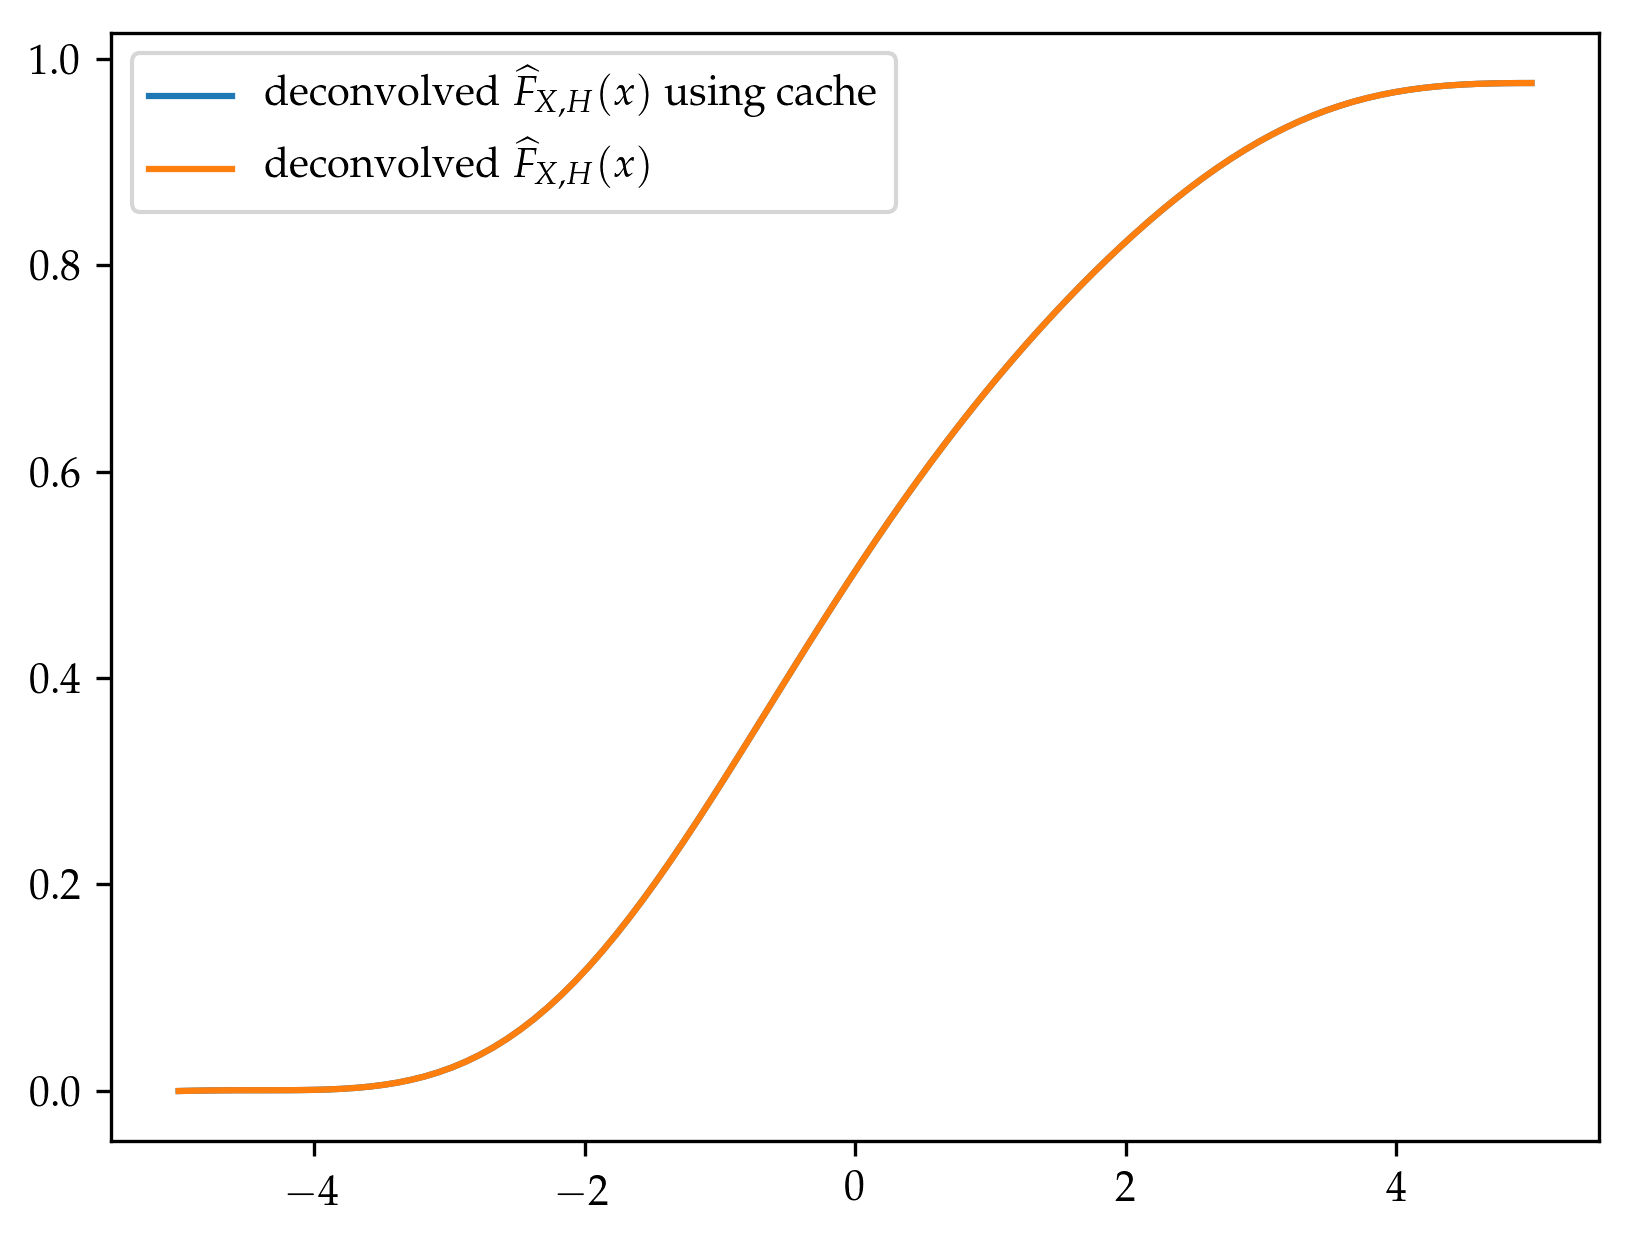

PyObject <matplotlib.legend.Legend object at 0x1356c0b38>

In [477]:
plt.plot(Fxx, Fhat_xx_cache, label=L"deconvolved $\widehat{F}_{X,H}(x)$ using cache")
plt.plot(Fxx, Fhat_xx, label=L"deconvolved $\widehat{F}_{X,H}(x)$")
plt.legend(loc="auto")

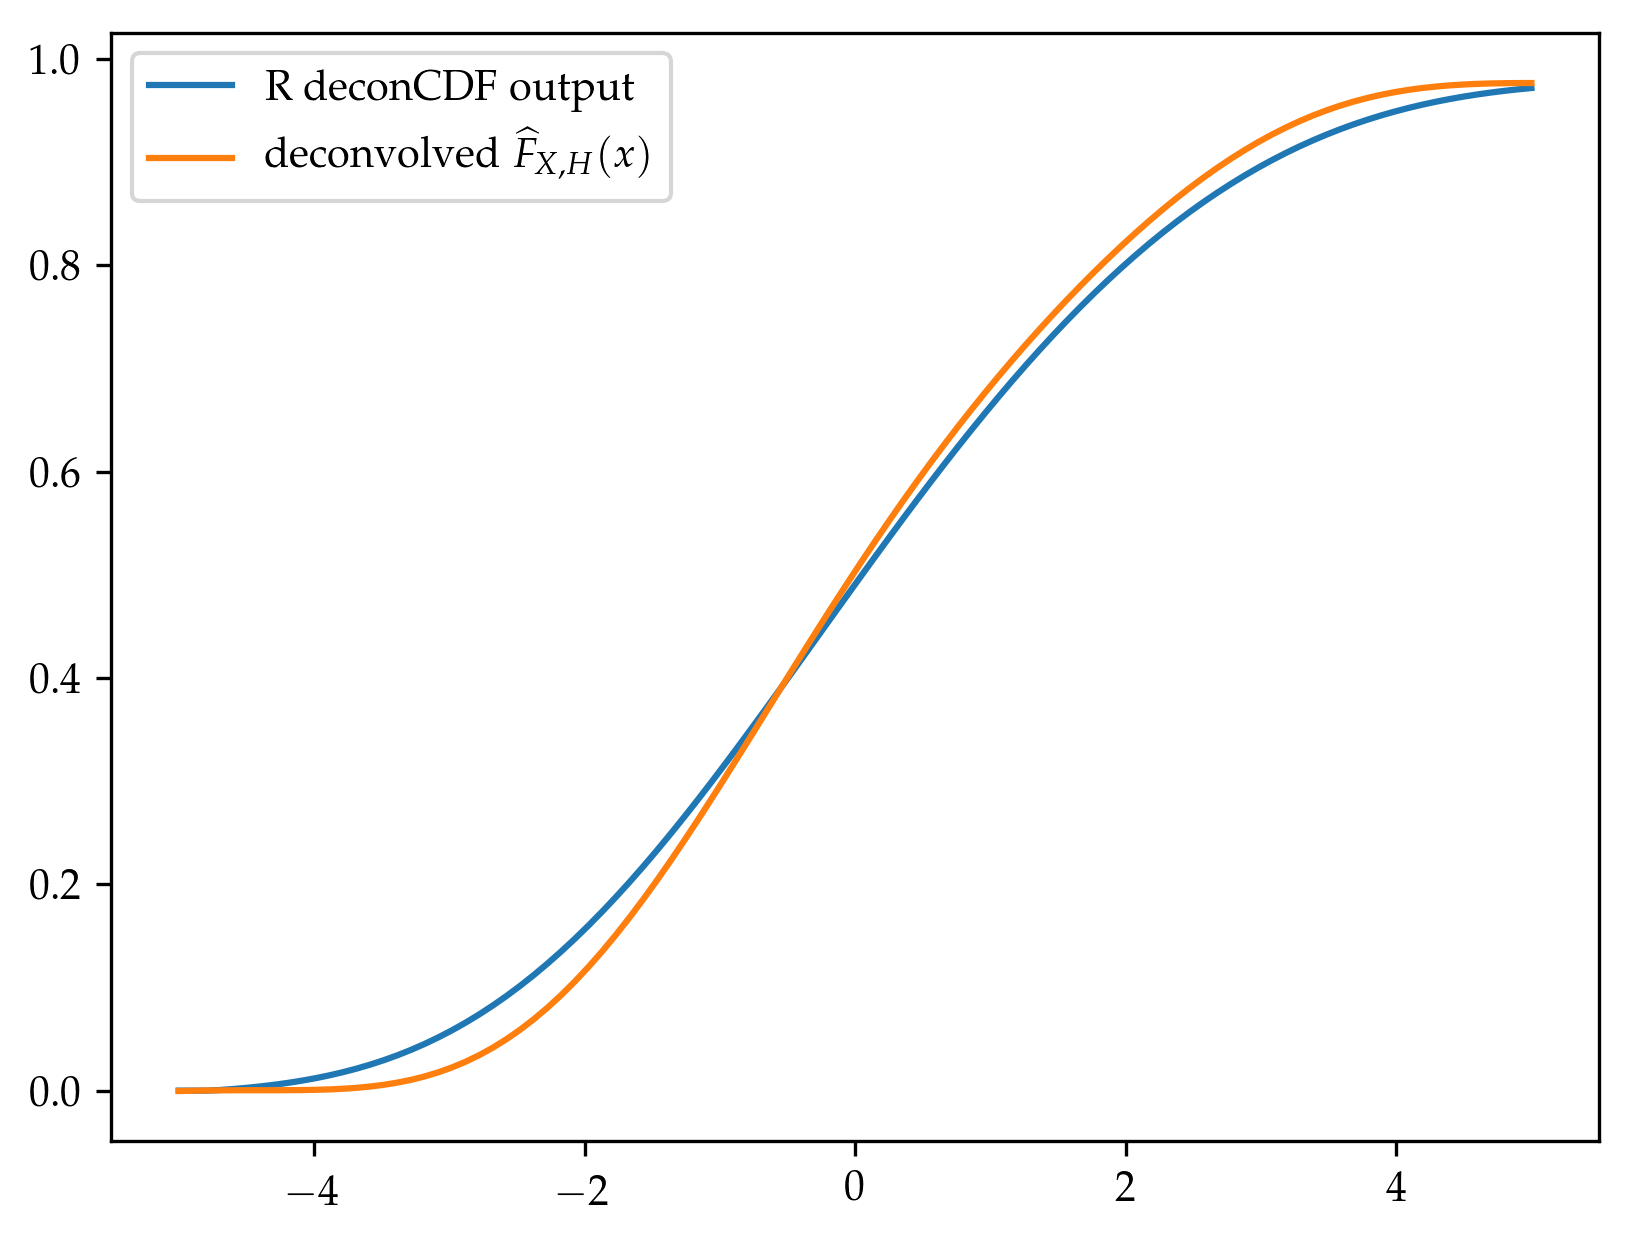

PyObject <matplotlib.legend.Legend object at 0x136291438>

In [478]:
plt.plot(Fxx, Fhat_R, label="R deconCDF output")
plt.plot(Fxx, Fhat_xx, label=L"deconvolved $\widehat{F}_{X,H}(x)$")
plt.legend(loc="auto")

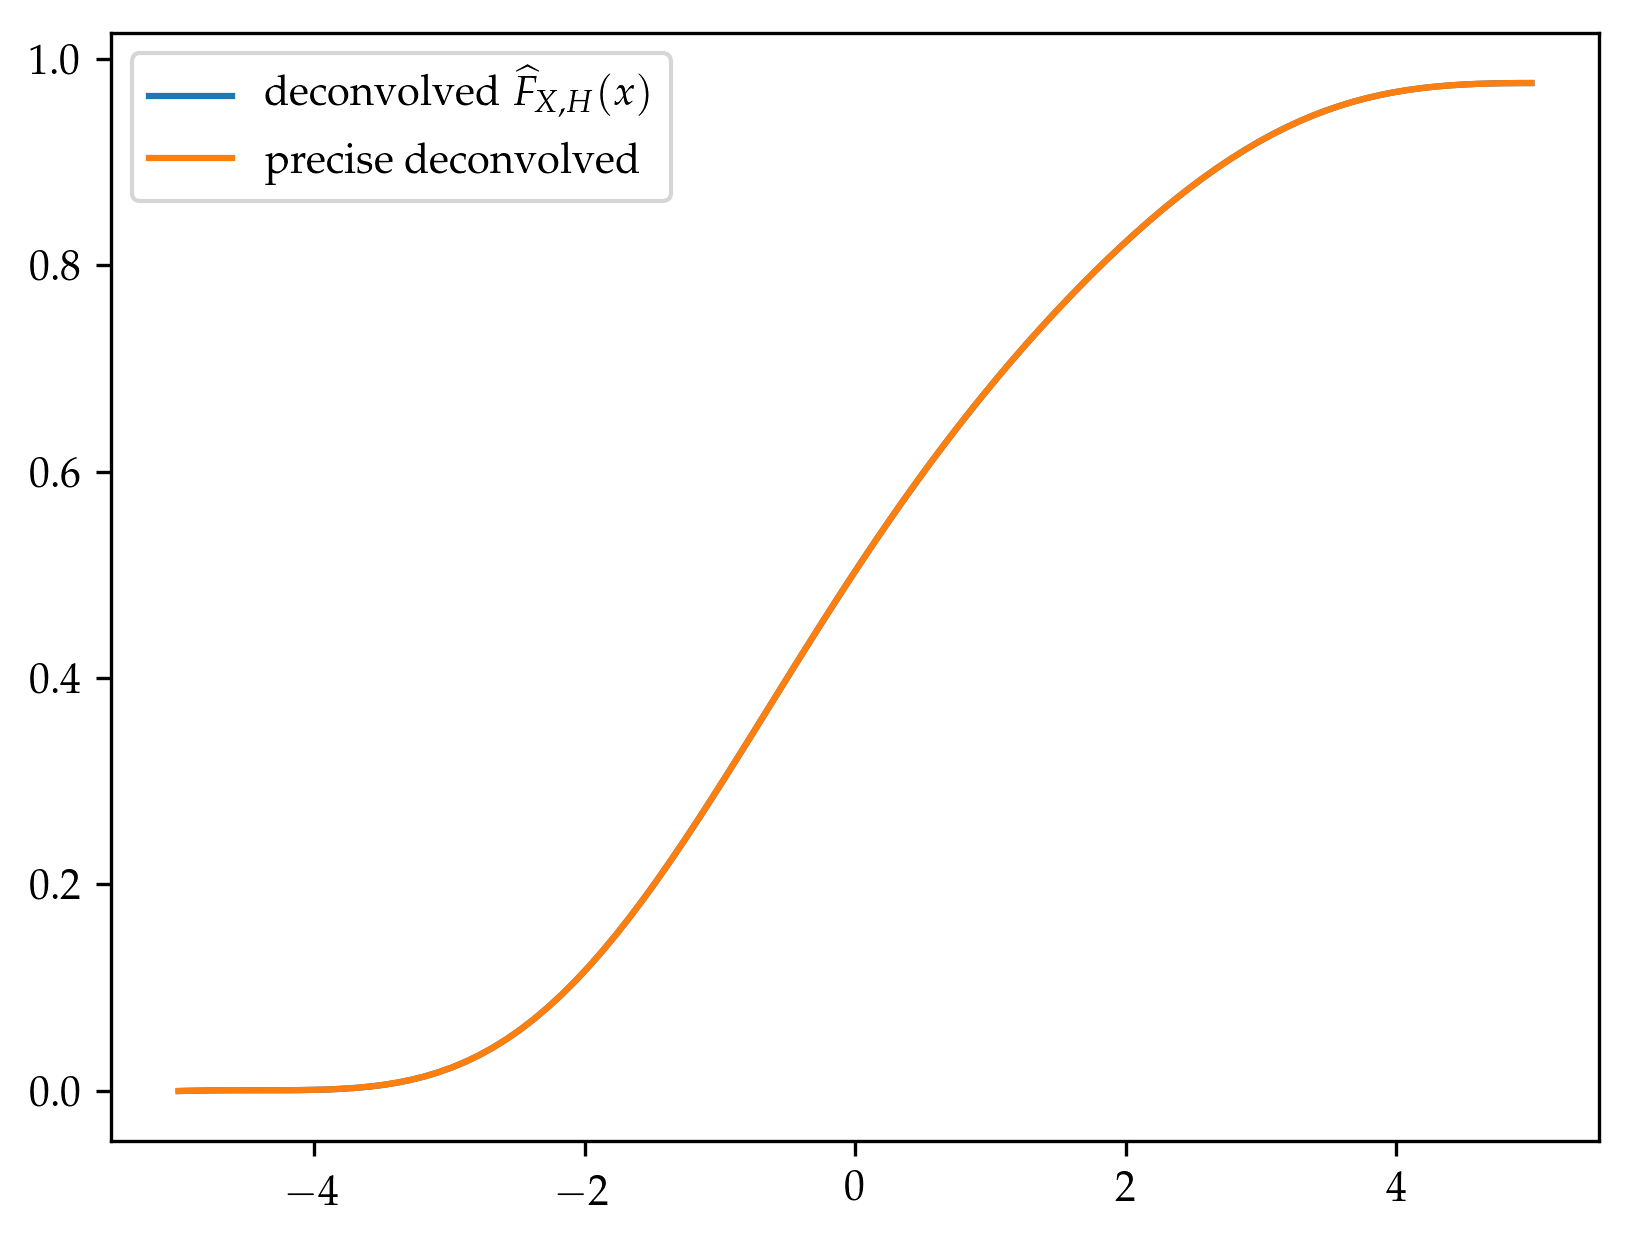

PyObject <matplotlib.legend.Legend object at 0x13561db38>

In [435]:
plt.plot(Fxx, Fhat_xx, label=L"deconvolved $\widehat{F}_{X,H}(x)$")
plt.plot(Fxx, Fhat_precise, label="precise deconvolved")
plt.legend(loc="auto")

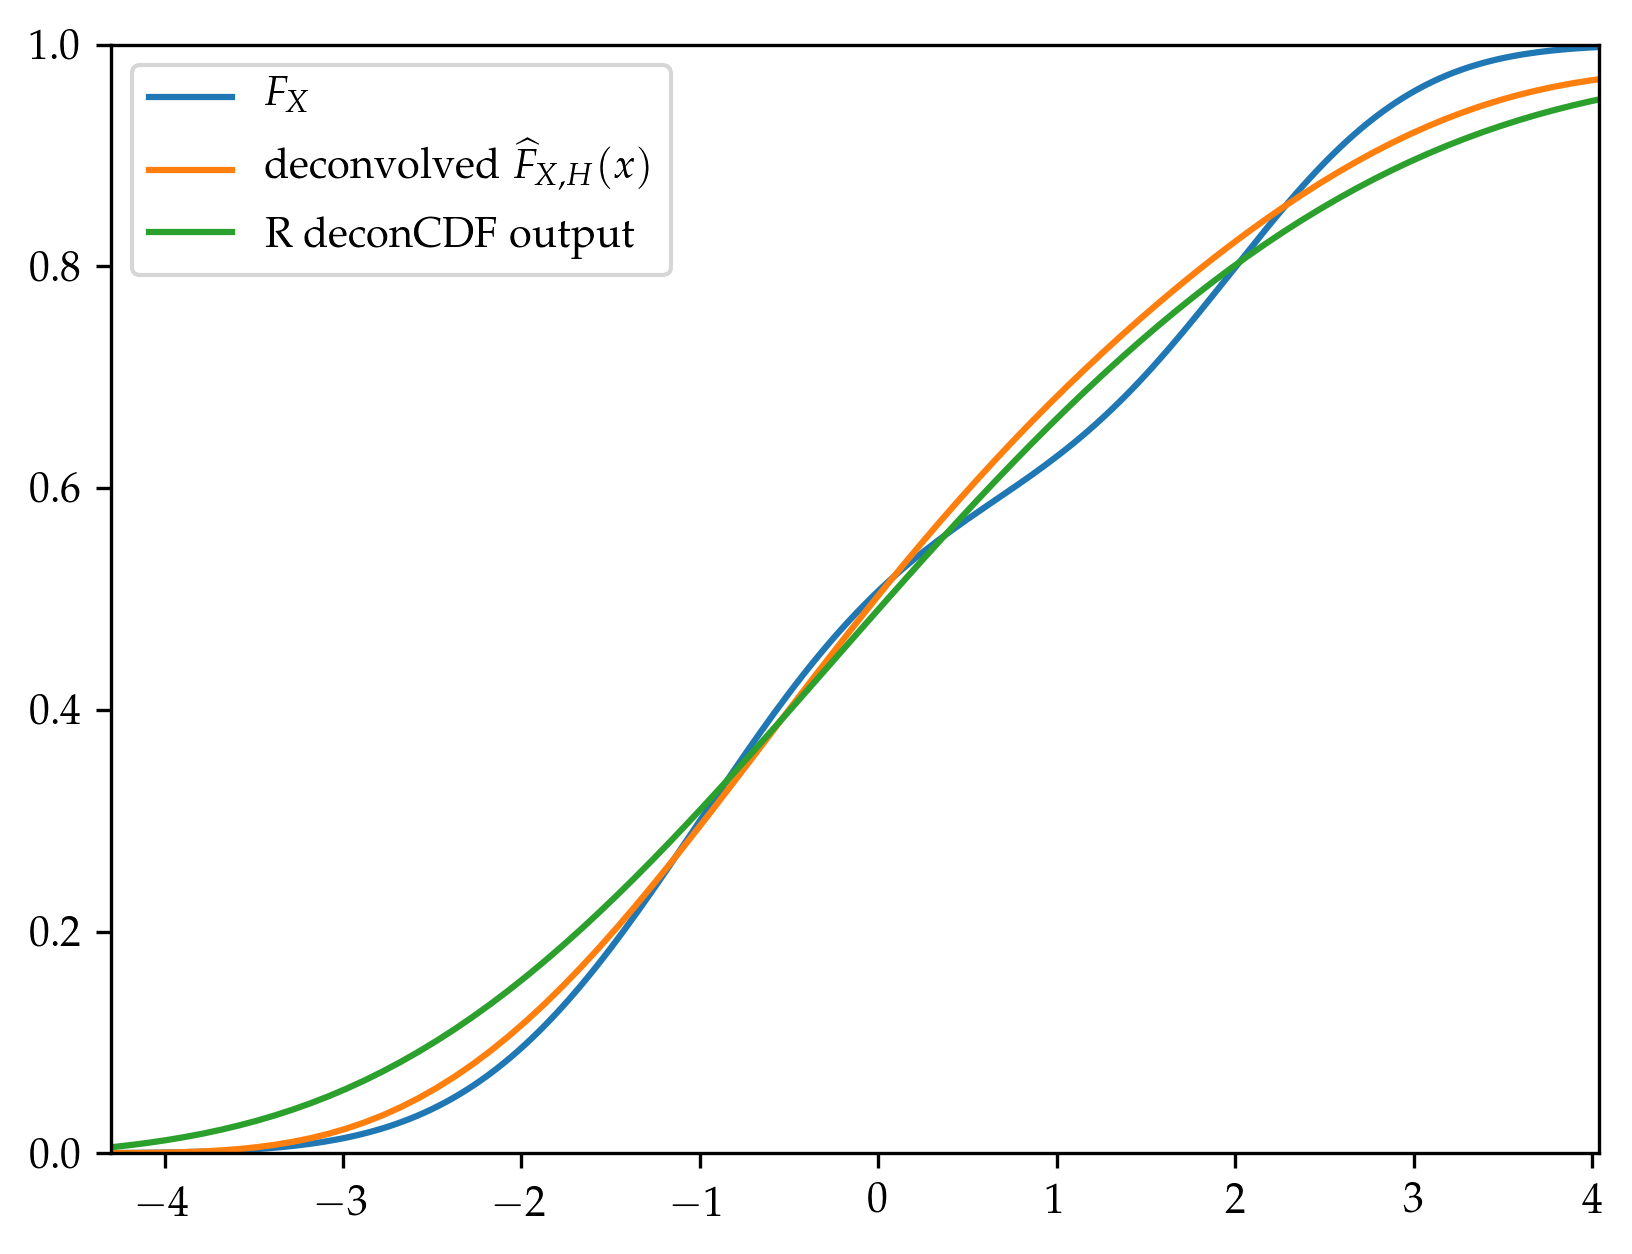

(0, 1)

In [482]:
xx = linspace(-20, 20, 1000)
plt.plot(xx, cdf.(F_X, xx), label=L"$F_X$")
bins = linspace(-20, 20, 100)
# plt.plot(sort(X), linspace(0,1,n), label=L"$X$ ECDF")
# plt.plot(sort(W), linspace(0,1,n), label=L"$W$ ECDF")
plt.plot(Fxx, Fhat_xx, label=L"deconvolved $\widehat{F}_{X,H}(x)$")
plt.plot(Fxx, Fhat_R, label="R deconCDF output")
plt.legend(loc="upper left")
plt.xlim(extrema(X)...)
plt.ylim(0,1)